In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
df = pd.read_csv('creditcard_small.csv')

In [4]:
# Simulated example
np.random.seed(42)

n_normal = 10000
n_anomaly = 200

# Normal transactions
normal_data = np.random.normal(0, 1, (n_normal, 30))

# Anomalous transactions (shifted mean)
anomaly_data = np.random.normal(4, 1, (n_anomaly, 30))

# Combine
X = np.vstack([normal_data, anomaly_data])
y = np.hstack([np.zeros(n_normal), np.ones(n_anomaly)])

df = pd.DataFrame(X)
df['Class'] = y

df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Class
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,...,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,0.0
1,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,...,-0.385082,-0.676922,0.611676,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,0.0
2,-0.479174,-0.185659,-1.106335,-1.196207,0.812526,1.356240,-0.072010,1.003533,0.361636,-0.645120,...,0.357113,1.477894,-0.518270,-0.808494,-0.501757,0.915402,0.328751,-0.529760,0.513267,0.0
3,0.097078,0.968645,-0.702053,-0.327662,-0.392108,-1.463515,0.296120,0.261055,0.005113,-0.234587,...,-0.026514,0.060230,2.463242,-0.192361,0.301547,-0.034712,-1.168678,1.142823,0.751933,0.0
4,0.791032,-0.909387,1.402794,-1.401851,0.586857,2.190456,-0.990536,-0.566298,0.099651,-0.503476,...,1.307143,-1.607483,0.184634,0.259883,0.781823,-1.236951,-1.320457,0.521942,0.296985,0.0


In [5]:
# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split normal vs anomalies
X_normal = X_scaled[y == 0]
X_anomaly = X_scaled[y == 1]

# Train / test split on normal
X_train, X_test_normal = train_test_split(X_normal, test_size=0.2, random_state=42)

# Combine test set with anomalies for evaluation
X_test = np.vstack([X_test_normal, X_anomaly])
y_test = np.hstack([np.zeros(len(X_test_normal)), np.ones(len(X_anomaly))])

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (8000, 30)
Test shape: (2200, 30)


In [6]:
input_dim = X_train.shape[1]

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,286 (5.02 KB)

 Trainable params: 1,286 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=256,
    validation_data=(X_test_normal, X_test_normal),
    verbose=2
)

Epoch 1/30
32/32 - 2s - 64ms/step - loss: 0.8000 - val_loss: 0.7640
Epoch 2/30
32/32 - 0s - 5ms/step - loss: 0.7549 - val_loss: 0.7398
Epoch 3/30
32/32 - 0s - 6ms/step - loss: 0.7339 - val_loss: 0.7210
Epoch 4/30
32/32 - 0s - 7ms/step - loss: 0.7138 - val_loss: 0.7009
Epoch 5/30
32/32 - 0s - 12ms/step - loss: 0.6920 - val_loss: 0.6784
Epoch 6/30
32/32 - 0s - 5ms/step - loss: 0.6681 - val_loss: 0.6546
Epoch 7/30
32/32 - 0s - 5ms/step - loss: 0.6442 - val_loss: 0.6337
Epoch 8/30
32/32 - 0s - 5ms/step - loss: 0.6264 - val_loss: 0.6194
Epoch 9/30
32/32 - 0s - 5ms/step - loss: 0.6147 - val_loss: 0.6105
Epoch 10/30
32/32 - 0s - 6ms/step - loss: 0.6068 - val_loss: 0.6033
Epoch 11/30
32/32 - 0s - 10ms/step - loss: 0.6005 - val_loss: 0.5980
Epoch 12/30
32/32 - 0s - 5ms/step - loss: 0.5956 - val_loss: 0.5940
Epoch 13/30
32/32 - 0s - 6ms/step - loss: 0.5915 - val_loss: 0.5902
Epoch 14/30
32/32 - 0s - 8ms/step - loss: 0.5881 - val_loss: 0.5873
Epoch 15/30
32/32 - 0s - 5ms/step - loss: 0.5854 - val

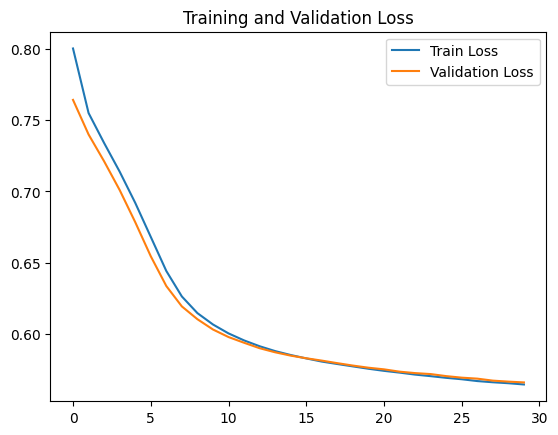

In [8]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [9]:
# Predict on test set
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)

# Add to DataFrame
results = pd.DataFrame({
    'reconstruction_error': reconstruction_error,
    'true_label': y_test
})

results.head()

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,reconstruction_error,true_label
0,0.682795,0.0
1,0.243180,0.0
2,0.501998,0.0
3,0.703831,0.0
4,0.402694,0.0


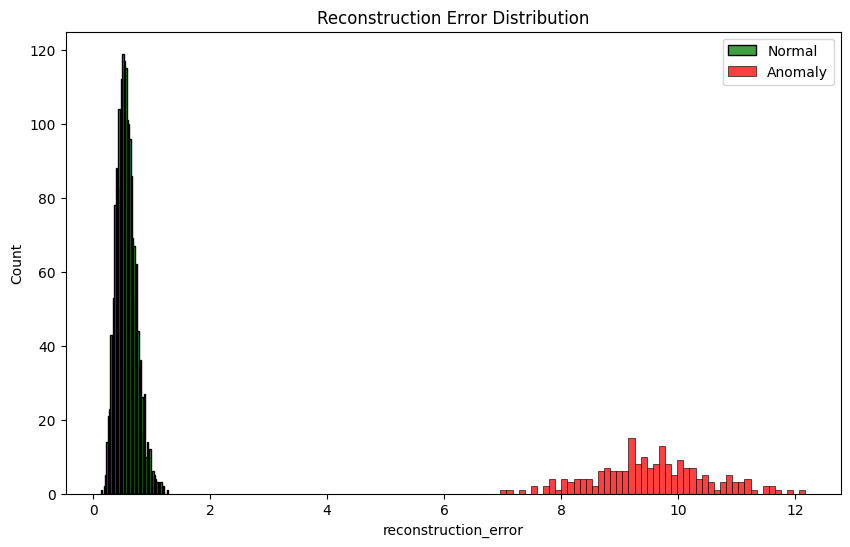

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(results[results.true_label == 0]['reconstruction_error'], bins=50, color='green', label='Normal')
sns.histplot(results[results.true_label == 1]['reconstruction_error'], bins=50, color='red', label='Anomaly')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

In [10]:
threshold = results[results.true_label == 0]['reconstruction_error'].quantile(0.99)
print(f"Chosen threshold: {threshold:.4f}")

Chosen threshold: 1.0477


In [11]:
results['predicted_label'] = (results['reconstruction_error'] > threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(results['true_label'], results['predicted_label']))
print(confusion_matrix(results['true_label'], results['predicted_label']))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2000
         1.0       0.91      1.00      0.95       200

    accuracy                           0.99      2200
   macro avg       0.95      0.99      0.97      2200
weighted avg       0.99      0.99      0.99      2200

[[1980   20]
 [   0  200]]
